In [390]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns,joblib
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,r2_score,mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import AdaBoostRegressor
from scipy.stats import zscore,boxcox

In [391]:
cvd=pd.read_csv('aggregate_covid_country.csv')

In [392]:
cvd.head()

,Date,Country,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,0,0,0
1,2020-01-22,Albania,0,0,0
2,2020-01-22,Algeria,0,0,0
3,2020-01-22,Andorra,0,0,0
4,2020-01-22,Angola,0,0,0


In [393]:
cvd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23688 entries, 0 to 23687
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       23688 non-null  object
 1   Country    23688 non-null  object
 2   Confirmed  23688 non-null  int64 
 3   Recovered  23688 non-null  int64 
 4   Deaths     23688 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 925.4+ KB


In [394]:
cvd.describe()

,Confirmed,Recovered,Deaths
count,2.368800e+04,23688.000000,23688.000000
mean,7.969368e+03,2581.801714,526.935030
std,5.842109e+04,15143.101257,3992.815956
min,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000
50%,1.800000e+01,1.000000,0.000000
75%,7.300000e+02,123.000000,13.000000
max,1.680913e+06,384902.000000,98913.000000


In [395]:
cvd['Date'].nunique()

126

In [396]:
cvd['Date'].value_counts()

2020-03-30    188
2020-03-19    188
2020-02-14    188
2020-04-02    188
2020-04-18    188
             ... 
2020-05-26    188
2020-01-29    188
2020-04-06    188
2020-02-12    188
2020-02-02    188
Name: Date, Length: 126, dtype: int64

In [397]:
cvd['Date']=pd.to_datetime(cvd['Date'],format='%Y-%m-%d')

In [398]:
cvd['Month']=cvd['Date'].dt.month

In [399]:
cvd.head()

,Date,Country,Confirmed,Recovered,Deaths,Month
0,2020-01-22,Afghanistan,0,0,0,1
1,2020-01-22,Albania,0,0,0,1
2,2020-01-22,Algeria,0,0,0,1
3,2020-01-22,Andorra,0,0,0,1
4,2020-01-22,Angola,0,0,0,1


In [400]:
cvd.drop('Date',axis=1,inplace=True)

In [401]:
cvd=cvd[['Month','Country','Confirmed','Recovered','Deaths']]

In [402]:
cvd.head()

,Month,Country,Confirmed,Recovered,Deaths
0,1,Afghanistan,0,0,0
1,1,Albania,0,0,0
2,1,Algeria,0,0,0
3,1,Andorra,0,0,0
4,1,Angola,0,0,0


In [403]:
cvd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23688 entries, 0 to 23687
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Month      23688 non-null  int64 
 1   Country    23688 non-null  object
 2   Confirmed  23688 non-null  int64 
 3   Recovered  23688 non-null  int64 
 4   Deaths     23688 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 925.4+ KB


In [404]:
le=LabelEncoder()

In [405]:
cvd['Country']=le.fit_transform(cvd['Country'])

In [406]:
cvd.head()

,Month,Country,Confirmed,Recovered,Deaths
0,1,0,0,0,0
1,1,1,0,0,0
2,1,2,0,0,0
3,1,3,0,0,0
4,1,4,0,0,0


In [407]:
cvd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23688 entries, 0 to 23687
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Month      23688 non-null  int64
 1   Country    23688 non-null  int64
 2   Confirmed  23688 non-null  int64
 3   Recovered  23688 non-null  int64
 4   Deaths     23688 non-null  int64
dtypes: int64(5)
memory usage: 925.4 KB


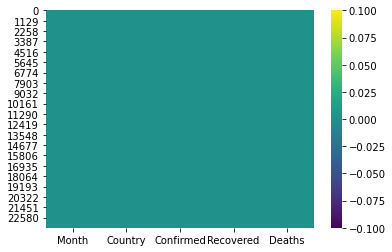

In [408]:
sns.heatmap(cvd.isna(),cmap='viridis')

In [409]:
sc=StandardScaler()
cvd_stan=sc.fit_transform(cvd)

In [410]:
cvd=pd.DataFrame(cvd_stan,columns=cvd.columns)

In [411]:
cvd.head()

,Month,Country,Confirmed,Recovered,Deaths
0,-1.821207,-1.722862,-0.136415,-0.170497,-0.131974
1,-1.821207,-1.704436,-0.136415,-0.170497,-0.131974
2,-1.821207,-1.686009,-0.136415,-0.170497,-0.131974
3,-1.821207,-1.667583,-0.136415,-0.170497,-0.131974
4,-1.821207,-1.649157,-0.136415,-0.170497,-0.131974


In [412]:
cvd.shape

(23688, 5)

In [413]:
zs=zscore(cvd)
cvd=cvd[(zs<3).all(axis=1)]

In [414]:
cvd.shape

(23177, 5)

In [415]:
cvd.skew()

Month       -0.080529
Country     -0.005144
Confirmed    6.906829
Recovered    7.472281
Deaths       9.729360
dtype: float64

In [416]:
for x in cvd.columns:
    if abs(cvd.loc[:,x].skew()>0.55):
        cvd.loc[:,x]=np.log1p(abs(cvd.loc[:,x]))

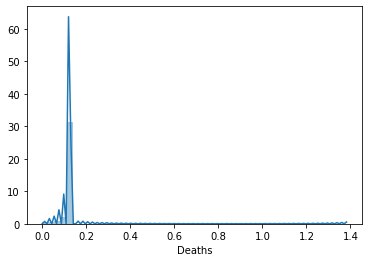

In [417]:
sns.distplot(cvd['Deaths'])

In [418]:
X=cvd.drop('Deaths',axis=1)
y=cvd.loc[:,'Deaths']

In [419]:
def model_select(model):
    max_score=0
    max_state=0
    for x in range(42,105):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=x)
        md=model()
        md.fit(X_train,y_train)
        md_predict=md.predict(X_test)
        r2score=r2_score(y_test,md_predict)
        if max_score<r2score:
            max_score=r2score
            max_state=x
    print("Max score is at {} for random state {}".format(max_score,max_state))

In [420]:
model_select(LinearRegression)

Max score is at 0.541733594497851 for random state 83


In [421]:
model_select(AdaBoostRegressor)

Max score is at 0.6849994811473525 for random state 93


In [422]:
model_select(Ridge)

Max score is at 0.5404073847294575 for random state 83


In [423]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=93)

In [424]:
param_list={'n_estimators':[1,5,10,20,40,50,60,80,100,110,150,200,220,250]}
gscv=GridSearchCV(AdaBoostRegressor(),param_list)
gscv.fit(X_train,y_train)
gscv.best_params_

{'n_estimators': 150}

In [425]:
ad=AdaBoostRegressor(n_estimators=150)
ad_predict=ad.fit(X_train,y_train).predict(X_test)

In [426]:
r2_score(y_test,ad_predict)

0.6493331260160422

In [427]:
MSE=mean_squared_error(y_test,ad_predict)
MSE

0.0023109555243284643

In [428]:
ad_predict.reshape(-1,1)

array([[0.12160663],
       [0.12123355],
       [0.12123355],
       ...,
       [0.12123355],
       [0.10771929],
       [0.12123355]])

In [429]:
sc=StandardScaler()
sc.fit(cvd['Deaths'].values.reshape(-1,1))
ad_predict=sc.inverse_transform(ad_predict.reshape(-1,1))

In [434]:
ad_predict.shape

(7649, 1)

In [437]:
joblib.dump(ad,'Ada_Covid.joblib')

['Ada_Covid.joblib']